In [1]:
# ШАГ 2: Импорты
import torch
import transformers
import pandas as pd
import numpy as np
import re
from datasets import Dataset
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# Скачиваем NLTK данные
nltk.download('stopwords')
nltk.download('wordnet')

# ШАГ 3: Проверка версий
print("PyTorch:", torch.__version__)
print("Transformers:", transformers.__version__)

2025-12-15 16:19:59.888757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765815600.102669      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765815600.167034      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

PyTorch: 2.6.0+cu124
Transformers: 4.53.3


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Загрузка данных
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
# Углублённая предобработка текста
def clean_text(text):
    text = re.sub(r'http[s]?://\S+', ' URL ', text)      # URL → "URL"
    text = re.sub(r'@\w+', ' @USER ', text)                 # @user → "@USER"
    text = re.sub(r'[^\w\s]', ' ', text)                   # Удаляем спецсимволы
    text = re.sub(r'\s+', ' ', text).strip().lower()      # Нормализуем пробелы
    return text

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

In [5]:
# Разделение на train и val
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['target'])

# Конвертация в Dataset
train_dataset = Dataset.from_dict({
    'text': train_df['clean_text'].tolist(),
    'label': train_df['target'].tolist()
})

val_dataset = Dataset.from_dict({
    'text': val_df['clean_text'].tolist(),
    'label': val_df['target'].tolist()
})

test_dataset = Dataset.from_dict({
    'text': test['clean_text'].tolist()
})

In [6]:
# Загрузка модели и токенизатора
model_name = 'xlm-roberta-large'    
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Вычисление весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(train['target']), y=train['target'])
class_weights = torch.tensor(class_weights).float()

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [7]:
from sklearn.metrics import accuracy_score, f1_score
from scipy.special import softmax

# 1. Сначала определяем функцию (в любом месте кода ДО создания Trainer)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    
    # Вычисляем accuracy и F1-score
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    
    return {"accuracy": acc, "f1": f1}

Средняя длина (train): 35 токенов
Макс. длина (train): 102 токенов
95‑й перцентиль (train): 54 токенов


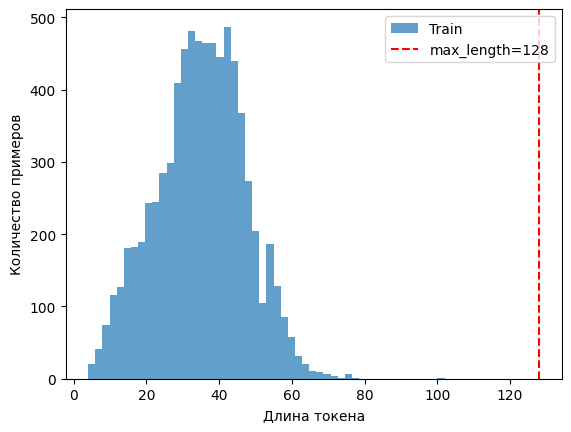

In [8]:
# Измеряем реальную длину токенов
train_lengths = [len(tokenizer.encode(text)) for text in train['text']]
test_lengths = [len(tokenizer.encode(text)) for text in test['text']]

print(f"Средняя длина (train): {np.mean(train_lengths):.0f} токенов")
print(f"Макс. длина (train): {np.max(train_lengths)} токенов")
print(f"95‑й перцентиль (train): {np.percentile(train_lengths, 95):.0f} токенов")


# Визуализация
import matplotlib.pyplot as plt
plt.hist(train_lengths, bins=50, alpha=0.7, label='Train')
plt.axvline(x=128, color='r', linestyle='--', label='max_length=128')
plt.xlabel('Длина токена')
plt.ylabel('Количество примеров')
plt.legend()
plt.show()


In [9]:
# Токенизация
def tokenize(batch):
    return tokenizer(
        batch['text'],
        padding='max_length',
        truncation=True,
        max_length=96,  
        return_tensors='pt'
    )

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [10]:
args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=7,           # Можно увеличить до 10, если есть время
    learning_rate=2e-5,       # Стандарт для RoBERTa
    warmup_ratio=0.1,
    weight_decay=0.01,        # Было 0.05 — слишком агрессивно
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=50,
    fp16=True,                  # Оставьте, если нет проблем со сходимостью
    seed=42,
    disable_tqdm=False,
    report_to="none",
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

In [11]:
# DataCollator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Trainer с валидацией и колбэком для ранней остановки
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics,  # ← добавить эту строку
)
# 7. Обучение
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.213100,0.500813,0.832567,0.802784


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=672, training_loss=0.31150357070423307, metrics={'train_runtime': 1838.5516, 'train_samples_per_second': 23.187, 'train_steps_per_second': 0.366, 'total_flos': 7449043878501120.0, 'train_loss': 0.31150357070423307, 'epoch': 7.0})

In [12]:
# 8. Предсказания
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
# 9. Сохранение
submission = pd.DataFrame({'id': test['id'], 'target': preds})
submission.to_csv('submission_roberta.csv', index=False)